# Kaggle Galaxies

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.plots import *
from IPython.core.debugger import set_trace
from sklearn.model_selection import StratifiedKFold

In [4]:
PATH = 'data/galaxy-zoo-2/'

# Exploring the data

## Initial Exploration

In [4]:
!ls {PATH}

all_ones_benchmark.csv	     models
all_zeros_benchmark.csv      tmp
central_pixel_benchmark.csv  training_solutions_joined.csv
images_test_rev1	     training_solutions_rev1.csv
images_training_rev1


In [5]:
!head {PATH}training_solutions_rev1.csv

In [6]:
!ls {PATH}images_training_rev1 | head

100008.jpg
100023.jpg
100053.jpg
100078.jpg
100090.jpg
100122.jpg
100123.jpg
100128.jpg
100134.jpg
100143.jpg
ls: write error: Broken pipe


In [7]:
!ls {PATH}images_test_rev1 | head

100018.jpg
100037.jpg
100042.jpg
100052.jpg
100056.jpg
100058.jpg
100062.jpg
100065.jpg
100071.jpg
100076.jpg
ls: write error: Broken pipe


In [8]:
!ls cat {PATH}images_training_rev1 | wc -l

ls: cannot access 'cat': No such file or directory
61579


In [9]:
!ls cat {PATH}images_test_rev1 | wc -l

ls: cannot access 'cat': No such file or directory
79976


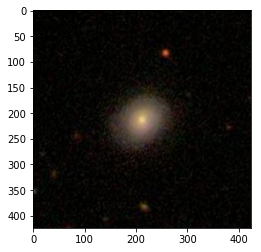

In [10]:
img = plt.imread(f'{PATH}/images_training_rev1/100008.jpg')
plt.imshow(img);

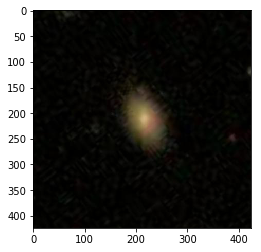

In [11]:
img = plt.imread(f'{PATH}/images_test_rev1/100018.jpg')
plt.imshow(img);

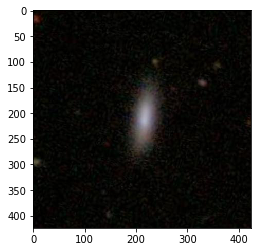

In [14]:
img = plt.imread(f'{PATH}/images_test_rev1/100042.jpg')
plt.imshow(img);

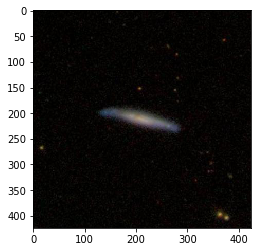

In [15]:
img = plt.imread(f'{PATH}/images_test_rev1/100056.jpg')
plt.imshow(img);

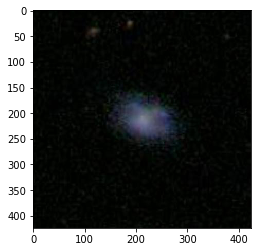

In [16]:
img = plt.imread(f'{PATH}/images_test_rev1/100058.jpg')
plt.imshow(img);

## Adapting CSV Data Loader to multi-classes

In [5]:
df = pd.read_csv(f'{PATH}training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [6]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    #tuples = [list(enumerate(probs)) for probs in probabilities]
    #pred_tuples_by_filename = {fname: t for fname, t in zip(fnames, tuples)}
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

In [7]:
def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class


In [17]:
fnames,y,idx2class = csv_source_multi_class('images_training_rev1', f'{PATH}training_solutions_rev1.csv', '')


In [20]:
y.shape

(61578, 37)

In [9]:
    @classmethod
    def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
               val_idxs=None, suffix='', test_name=None, num_workers=8):
        """ Read in images and their labels given as a CSV file.
--
        This method should be used when training image labels are given in an CSV file as opposed to
        sub-directories with label names.

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            folder: a name of the folder in which training images are contained.
            csv_fname: a name of the CSV file which contains target labels.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
                If None, default arguments to get_cv_idxs are used.
            suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                    extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
            test_name: a name of the folder which contains test images.
            skip_header: skip the first row of the CSV file.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)
       
        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

        test_fnames = read_dir(path, test_name) if test_name else None
        #if continuous:
        # This sets 'reg' to true, do we need 'multi' as well, without the onehot encoding?
        f = FilesIndexArrayRegressionDataset
        #else:
        #    f = FilesIndexArrayDataset if len(trn_y.shape)==1 else FilesNhotArrayDataset
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))
    
ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [10]:
arch = resnet34
batch_size = 64
img_size = 400

solution_csv = f'{PATH}training_solutions_rev1.csv'
n_training = len(list(open(solution_csv)))-1
val_idxs = get_cv_idxs(n_training)

transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg')

## Image Sizes

In [17]:
sizes = {filename: PIL.Image.open(PATH+filename).size for filename in data.trn_ds.fnames}
rows_sizes, cols_sizes = zip(*sizes.values())
rows_sizes = np.array(rows_sizes)
cols_sizes = np.array(cols_sizes)
rows_sizes[:5]

array([424, 424, 424, 424, 424])

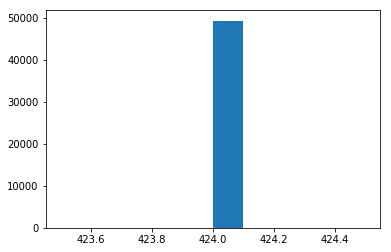

In [18]:
plt.hist(rows_sizes);

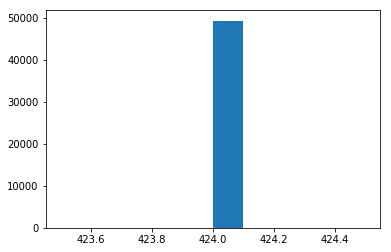

In [19]:
plt.hist(cols_sizes);

In [20]:
len(data.trn_ds), len(data.test_ds)

(49263, 79975)

# Throw a first model at that :)

In [8]:
arch = resnet34
batch_size = 128
img_size = 424

transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

In [9]:
learn = ConvLearner.pretrained(arch, data)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

100%|█████████▉| 769/770 [08:38<00:00,  1.48it/s, loss=0.496]

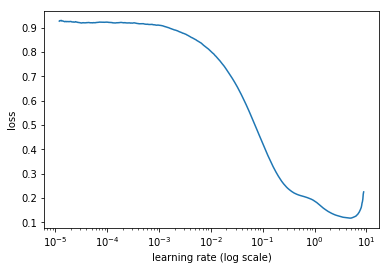

In [10]:
learn.lr_find()
learn.sched.plot()

In [11]:
lr = .1

In [12]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 16/770 [00:09<07:40,  1.64it/s, loss=0.809] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      0.09482    0.084245  



[0.08424504]

Let's check our evalutation metrics against Kaggle

In [33]:
augmented_preds, y = learn.TTA(is_test=True)

In [35]:
len(data.test_ds), augmented_preds.shape

(79975, (5, 79975, 37))

In [44]:
augmented_preds

array([[[ 0.373  ,  0.62168,  0.02883, ...,  0.00885,  0.00187,  0.03988],
        [ 0.61797,  0.3471 ,  0.03591, ...,  0.02435, -0.08027,  0.06054],
        [ 0.43806,  0.54417,  0.02637, ..., -0.00955, -0.05328,  0.06987],
        ...,
        [ 0.71748,  0.22613,  0.04022, ...,  0.04116, -0.03372,  0.02891],
        [ 0.42109,  0.60585,  0.00847, ...,  0.01253,  0.01375,  0.03796],
        [ 0.81259,  0.16695,  0.05012, ..., -0.01371,  0.01244,  0.06855]],

       [[ 0.373  ,  0.62168,  0.02883, ...,  0.00885,  0.00187,  0.03988],
        [ 0.61797,  0.3471 ,  0.03591, ...,  0.02435, -0.08027,  0.06054],
        [ 0.43806,  0.54417,  0.02637, ..., -0.00955, -0.05328,  0.06987],
        ...,
        [ 0.71748,  0.22613,  0.04022, ...,  0.04116, -0.03372,  0.02891],
        [ 0.42109,  0.60585,  0.00847, ...,  0.01253,  0.01375,  0.03796],
        [ 0.81259,  0.16695,  0.05012, ..., -0.01371,  0.01244,  0.06855]],

       [[ 0.373  ,  0.62168,  0.02883, ...,  0.00885,  0.00187,  0.039

In [47]:
preds = np.mean(augmented_preds, axis=0)
preds.shape

(79975, 37)

File format from Kaggle:

GalaxyId,Class1.1,Class1.2,Class1.3,Class2.1, ..., Class11.5, Class11.6

100002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

100003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

100004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

etc...

In [48]:
data.test_ds.fnames[:10]

['images_test_rev1/374452.jpg',
 'images_test_rev1/164700.jpg',
 'images_test_rev1/514831.jpg',
 'images_test_rev1/490367.jpg',
 'images_test_rev1/703955.jpg',
 'images_test_rev1/443009.jpg',
 'images_test_rev1/756164.jpg',
 'images_test_rev1/577570.jpg',
 'images_test_rev1/102681.jpg',
 'images_test_rev1/236942.jpg']

In [49]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])
df.head()

,GalaxyId,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,374452,0.373004,0.621678,0.028831,0.014799,0.550714,0.014433,0.405267,0.159085,0.282582,...,0.001217,0.084817,0.015461,0.025697,0.000558,0.059687,0.022945,0.008848,0.001866,0.039877
1,164700,0.617973,0.347099,0.035914,-0.070751,0.291786,0.145155,0.115240,0.026606,0.079265,...,-0.058414,-0.039101,0.128175,-0.053115,0.006429,0.013535,-0.041397,0.024354,-0.080267,0.060539
2,514831,0.438061,0.544172,0.026373,-0.071118,0.490575,0.052954,0.276420,0.137684,0.197563,...,-0.019456,0.055186,0.085162,-0.048598,0.006127,0.041606,-0.029589,-0.009548,-0.053281,0.069869
3,490367,0.301551,0.710361,0.016661,0.156187,0.423554,0.013685,0.328356,0.128850,0.225354,...,0.074230,0.042397,-0.009148,0.016447,0.006132,0.000052,0.020343,0.009896,0.015110,0.053223
4,703955,0.367161,0.586874,0.010141,0.051141,0.531089,0.055344,0.383171,0.255797,0.212555,...,0.043476,0.145516,0.063974,0.022476,0.008095,0.073346,0.028551,-0.000907,0.025280,0.085514


In [50]:
SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnet_test.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/paperspace/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnet_test.gz

Hmm, kaggle gives this a loss of 0.14305, which is WAY off our validation_loss of 0.085662

# Figure out a better validation metric

**(I'm assuming the validation set is okay, with this amount of data)**

### Check if TTA() is messing anything up

In [57]:
preds = learn.predict(is_test=True)

In [58]:
preds.shape

(79975, 37)

In [59]:
preds[:10]

array([[ 0.373  ,  0.62168,  0.02883,  0.0148 ,  0.55071,  0.01443,  0.40527,  0.15908,  0.28258,  0.03676,
         0.19122,  0.17587,  0.00711,  0.18815,  0.80929,  0.07396,  0.13501, -0.01824, -0.01322,  0.01856,
         0.05715,  0.03292,  0.02802,  0.01198,  0.00332,  0.02064,  0.00258,  0.00122,  0.08482,  0.01546,
         0.0257 ,  0.00056,  0.05969,  0.02294,  0.00885,  0.00187,  0.03988],
       [ 0.61797,  0.3471 ,  0.03591, -0.07075,  0.29179,  0.14515,  0.11524,  0.02661,  0.07927,  0.02681,
         0.1638 , -0.01972,  0.04368, -0.06377,  1.07616,  0.24114,  0.19759,  0.12262,  0.03574, -0.05892,
        -0.02169, -0.08003,  0.0007 , -0.0127 , -0.02828, -0.0617 , -0.02254, -0.05841, -0.0391 ,  0.12817,
        -0.05311,  0.00643,  0.01353, -0.0414 ,  0.02435, -0.08027,  0.06054],
       [ 0.43806,  0.54417,  0.02637, -0.07112,  0.49058,  0.05295,  0.27642,  0.13768,  0.19756,  0.05569,
         0.28141, -0.00279,  0.03885,  0.03096,  0.93497,  0.2322 ,  0.14429,  0.05269

In [60]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnet_test_no_TTA.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/paperspace/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnet_test_no_TTA.gz

Perfect, no bugs there.

## Correctly switch to RMSE as evaluation metric

In [9]:
def rmse (x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [10]:
metrics = [rmse]

learn = ConvLearner.pretrained(arch, data)

In [11]:
learn.crit = rmse

In [17]:
learn.crit

<function __main__.rmse>

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.252713   0.80911   



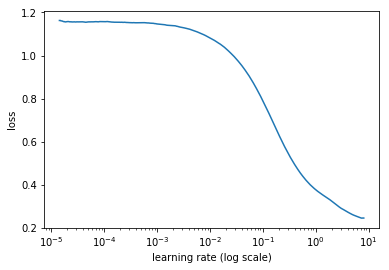

In [12]:
learn.lr_find()
learn.sched.plot()

In [13]:
lr = .1
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.148622   0.136722  



[0.13672246]

Bingo!

In [15]:
learn.save('resnet34')

# Resnet34 validation metrics evaluation, Take II

In [7]:
arch = resnet34
batch_size = 128
img_size = 424

solution_csv = f'{PATH}training_solutions_rev1.csv'
n_training = len(list(open(solution_csv)))-1
val_idxs = get_cv_idxs(n_training)

transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

In [8]:
def rmse (x, y):
    return torch.sqrt(F.mse_loss(x,y))

learn = ConvLearner.pretrained(arch, data)
lr = .1
learn.load('resnet34')

metrics = [rmse]
learn.crit = rmse

In [9]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.143592   0.136153  



[0.13615309]

In [10]:
learn.save('resnet34')

Let's submit to re-check our validation metrics

In [11]:
preds = learn.predict(is_test=True)

In [12]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnet_eval_test.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/paperspace/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnet_eval_test.gz

Excellent, validation set and metrics looking good!

# Are we using the right final fc layer activation function?

In [17]:
learn[-1]

Linear(in_features=512, out_features=37, bias=True)

In [19]:
data.trn_y[:2]

array([[0.38315, 0.61685, 0.     , 0.     , 0.61685, 0.03845, 0.5784 , 0.4184 , 0.19846, 0.     , 0.10475,
        0.5121 , 0.     , 0.05445, 0.94555, 0.20146, 0.18168, 0.     , 0.     , 0.02723, 0.     , 0.02723,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.27995, 0.13845, 0.     , 0.     , 0.09289,
        0.     , 0.     , 0.     , 0.32551],
       [0.327  , 0.66378, 0.00922, 0.03118, 0.6326 , 0.46737, 0.16523, 0.59133, 0.04127, 0.     , 0.23678,
        0.16094, 0.23488, 0.18915, 0.81085, 0.     , 0.13508, 0.19192, 0.     , 0.     , 0.14035, 0.     ,
        0.0488 , 0.     , 0.     , 0.01241, 0.     , 0.01876, 0.     , 0.13138, 0.45995, 0.     , 0.59133,
        0.     , 0.     , 0.     , 0.     ]], dtype=float32)

In [20]:
preds[:2]

array([[ 0.34786,  0.63448,  0.01655,  0.07464,  0.55853,  0.13123,  0.43046,  0.24267,  0.32114,  0.04384,
         0.25073,  0.2276 ,  0.04923,  0.15732,  0.83665,  0.08274,  0.22762,  0.03022,  0.04679,  0.01518,
         0.03313,  0.04474,  0.02134,  0.0057 , -0.00511,  0.06029, -0.00099,  0.01245,  0.13716,  0.08902,
         0.01055,  0.02265,  0.07698,  0.0125 ,  0.00698,  0.00828,  0.11418],
       [ 0.61573,  0.35926,  0.02403, -0.0446 ,  0.39641,  0.08105,  0.32214,  0.09732,  0.2963 ,  0.00566,
         0.16873,  0.17346,  0.0401 ,  0.30535,  0.69567,  0.19388,  0.3926 ,  0.03269,  0.0618 ,  0.0064 ,
         0.07281,  0.03954,  0.06227,  0.07885, -0.00732,  0.00923,  0.00621, -0.04885,  0.05623,  0.05284,
        -0.00906,  0.01742, -0.00164,  0.01291,  0.00642,  0.02474,  0.04975]], dtype=float32)

Let's get rid of those negatives...

Looks like we're using no activation in the final layer, let's set `is_multi` to true and `is_reg` to false to get sigmoid!

In [6]:
    @classmethod
    def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
               val_idxs=None, suffix='', test_name=None, num_workers=8):
        """ Read in images and their labels given as a CSV file.
--
        This method should be used when training image labels are given in an CSV file as opposed to
        sub-directories with label names.

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            folder: a name of the folder in which training images are contained.
            csv_fname: a name of the CSV file which contains target labels.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
                If None, default arguments to get_cv_idxs are used.
            suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                    extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
            test_name: a name of the folder which contains test images.
            skip_header: skip the first row of the CSV file.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)
       
        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

        test_fnames = read_dir(path, test_name) if test_name else None
        f = FilesNhotArrayDataset
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))
    
ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [7]:
arch = resnet34
batch_size = 128
img_size = 424

solution_csv = f'{PATH}training_solutions_rev1.csv'
n_training = len(list(open(solution_csv)))-1
val_idxs = get_cv_idxs(n_training)

transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

In [8]:
def rmse (x, y):
    return torch.sqrt(F.mse_loss(x,y))

learn = ConvLearner.pretrained(arch, data)
lr = .1

metrics = [rmse]
learn.crit = rmse

In [10]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.146936   0.134842   0.494038  



[0.13484196, 0.4940384144021064]

In [14]:
val_preds = learn.predict()
val_preds[:10]

array([[0.6659 , 0.27456, 0.01546, 0.01521, 0.25431, 0.04097, 0.26473, 0.0697 , 0.25415, 0.00642, 0.06819,
        0.21889, 0.00934, 0.17452, 0.8254 , 0.44454, 0.24219, 0.01792, 0.01634, 0.01279, 0.00766, 0.01382,
        0.04387, 0.01434, 0.00786, 0.0129 , 0.00727, 0.01151, 0.029  , 0.03179, 0.01441, 0.0056 , 0.04971,
        0.0148 , 0.01819, 0.01187, 0.02853],
       [0.75877, 0.21974, 0.01687, 0.01128, 0.20811, 0.02283, 0.19775, 0.02796, 0.221  , 0.00622, 0.02878,
        0.15515, 0.01167, 0.17576, 0.86363, 0.41735, 0.24499, 0.01332, 0.00918, 0.01942, 0.00817, 0.01877,
        0.02417, 0.03085, 0.01388, 0.01873, 0.00722, 0.0055 , 0.01514, 0.00944, 0.00705, 0.01173, 0.00937,
        0.00626, 0.0058 , 0.00894, 0.02407],
       [0.7649 , 0.21934, 0.02212, 0.04388, 0.15171, 0.02348, 0.16264, 0.04747, 0.15158, 0.02418, 0.06325,
        0.09668, 0.01916, 0.27767, 0.689  , 0.32105, 0.32042, 0.03972, 0.01809, 0.01503, 0.0154 , 0.02456,
        0.04938, 0.03322, 0.01389, 0.03887, 0.00923, 0

Aw yeah, this is looking better with Sigmoid! Let's make sure our validation metrics are still correct...

In [15]:
preds = learn.predict(is_test=True)

In [17]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnet_eval_test2.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/paperspace/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnet_eval_test2.gz

In [20]:
learn.save('resnet34')

Excellent! Kaggle is in agreement.

# How far will resnet34 get us?

In [9]:
learn.load('resnet34')

In [ ]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

Next Steps:

1. Start with smaller images (106) and unfreeze...
1. Does fiddling with wd makes a difference?
2. If overfitting, add data aug
3. If overfitting further, add dropout
4. Increase img size until twice until 424
5. Try a larger arch if needed
6. Ensemble?
7. TTA
8. Add validation set

In [9]:
img_size = 424 // 4
transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

learn.set_data(data)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.185922   0.152484   0.493381  



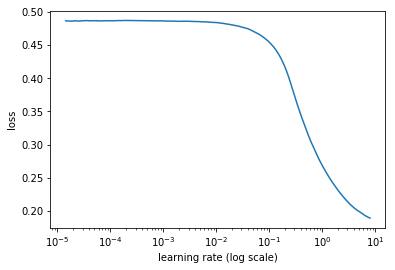

In [10]:
learn.lr_find()
learn.sched.plot()

In [11]:
lr = 1

In [12]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.138119   0.131207   0.494091  



[0.1312073, 0.4940906591022137]

In [13]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.132023   0.127949   0.49406   
    1      0.13108    0.127185   0.494086                    
    2      0.129964   0.126569   0.494091                    



[0.1265689, 0.49409066063841595]

## Unfreezing

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.130197   0.211494   0.493216  



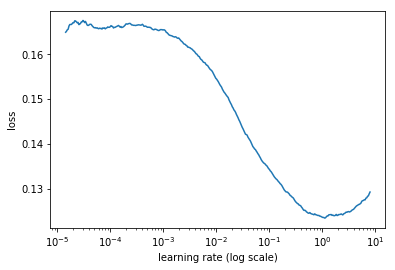

In [14]:
learn.unfreeze()

learn.lr_find()
learn.sched.plot()

Does lr_find() keep any weights? It started off at 0.165...

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.130943   0.273043   0.486929  



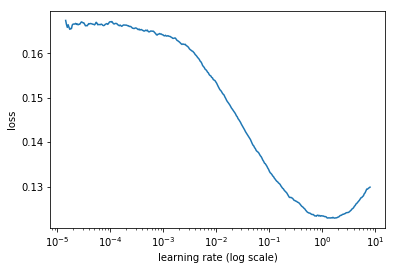

In [15]:
learn.lr_find()
learn.sched.plot()

Great, it doesn't

In [16]:
lr = [1e-5, 1e-3, 1e-1]

In [17]:
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.142473   0.137338   0.493927  
    1      0.13354    0.131605   0.493999                    
    2      0.130563   0.128163   0.494001                    



[0.12816337, 0.4940014097493948]

In [18]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.128343   0.127055   0.494054  
    1      0.127181   0.12588    0.494051                    
    2      0.125848   0.124866   0.494082                    



[0.12486566, 0.4940819516009891]

Let's try some WD...

In [20]:
learn.save('wd_test')

With...

In [21]:
wd = 5e-4

learn.fit(lr, 3, cycle_len=1, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  3%|▎         | 10/385 [00:04<03:05,  2.02it/s, loss=0.126]


Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>                    
    0      0.124631   0.123856   0.494112  
    1      0.124277   0.123615   0.494117                    
    2      0.123889   0.122988   0.494108                    



[0.1229876, 0.49410807256846084]

Without...

In [22]:
learn.load('wd_test')
learn.fit(lr, 3, cycle_len=1, wds=None)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.123216   0.123443   0.494062  
    1      0.12274    0.122507   0.494091                    
    2      0.12269    0.121731   0.494102                    



[0.12173142, 0.49410154370917486]

Still seems to be training better without!

In [23]:
learn.save('resnet34_116')

In [25]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.122319   0.121255   0.494128  
    1      0.120618   0.12022    0.494125                    
    2      0.119963   0.120063   0.494117                    
    3      0.119583   0.11929    0.494152                    
    4      0.11874    0.11863    0.494154                    
    5      0.11847    0.118395   0.494156                    
    6      0.118337   0.118236   0.494128                    



[0.11823575, 0.4941276637549253]

In [26]:
learn.save('resnet34_116')

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.117668   0.118079   0.494102  
    1      0.117355   0.117398   0.494184                    
    2      0.117234   0.117284   0.494182                    
    3      0.116741   0.116841   0.494145                    
    4      0.116552   0.116427   0.494169                    
    5      0.115359   0.116214   0.494171                    
    6      0.115256   0.116168   0.494143                    



[0.11616809, 0.49414290165163804]

In [32]:
learn.save('resnet34_116')

# Does adding dropout improve training on the smaller images?

In [30]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [31]:
learn = ConvLearner.pretrained(arch, data, ps=0.5)
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Ok, so the only thing that changes is Dropout in layer 11, i.e. b4 the first Linear layer

Let's leave that for now.

# Continue training on half size

In [33]:
img_size = 424 // 2
transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

learn.set_data(data)
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.315288   5.079629   0.470396  



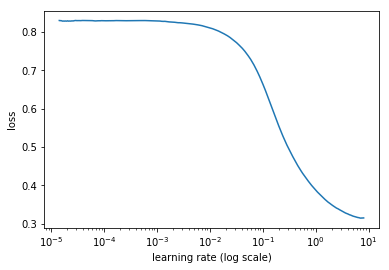

In [34]:
learn.lr_find()
learn.sched.plot()

Did unfreezing again after feeding new data have any effect?

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.327078   4.496835   0.469166  



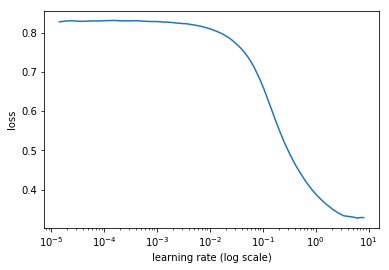

In [35]:
learn.load('resnet34_116')
learn.lr_find()
learn.sched.plot()

In [36]:
lr = [1e-4, 1e-2, 1]

In [37]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.257937   0.253469   0.494073  



[0.25346935, 0.4940732431780432]

In [38]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.25227    0.250251   0.494215  
    1      0.250901   0.248668   0.494217                    
    2      0.250006   0.247454   0.494241                    



[0.24745381, 0.49424085819844116]

# Can we turn off dropout completely?

In [39]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [41]:
learn = ConvLearner.pretrained(arch, data, ps=0)
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Yup, turns out we could :)

Still, let's move on to finding an architecture that doesn't underfit first...

# ResNext101

In [9]:
arch = resnext101_64
batch_size = 16
# RAM on this paperspace can't handle more, sadly
img_size = 424 // 2 
transforms = tfms_from_model(arch, img_size)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.158119   0.16695    0.493974  



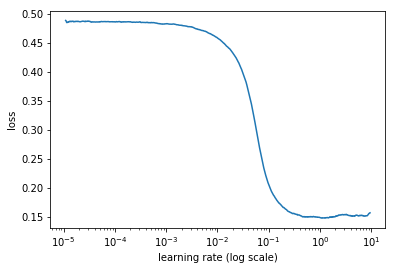

In [12]:
learn.lr_find()
learn.sched.plot()

In [10]:
lr = 1e-1

In [11]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.132055   0.123161   0.494185  



[0.12316098, 0.4941845264527705]

# Try unfreezing(), then loading larger images

In [16]:
learn.save('resnext101_212')

In [10]:
learn.load('resnext101_212')

In [10]:
lr = [1e-5, 1e-3, 1e-1]

learn.unfreeze()

In [12]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.113198   0.105077   0.494344  



[0.105076775, 0.4943443079660465]

In [13]:
learn.save('resnext101_212')

In [11]:
learn.load('resnext101_212')

In [12]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.106991   0.100097   0.494368  
    1      0.105719   0.098176   0.494406                      
    2      0.10348    0.096999   0.49441                        



[0.09699905, 0.49441012020234937]

In [13]:
learn.save('resnext101_212')

In [11]:
learn.load('resnext101_212')

In [12]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                       
    0      0.10111    0.096568   0.494412  
    1      0.100525   0.095505   0.494382                       
    2      0.096441   0.094909   0.494404                       
    3      0.097328   0.096117   0.494355                       
    4      0.093915   0.094438   0.494393                       
    5      0.090053   0.094698   0.494377                       
    6      0.086794   0.094548   0.494377                       



[0.09454752, 0.4943772137939156]

Next Steps:


1. Set up a large AWS instance

1. Increase image size

1. Train until overfitting, add data augmentation, see if we can improve

1. Can I improve the final activation function somehow? Look at the training data to find patterns that could be mathematically approximated

1. Any pre-processing on the images?

2. Try k-folding on resnext

3. Train an inception

4. Do resnext-inception ensembling

5. Train a nasnet

In [11]:
learn.load('resnext101_212')

In [14]:
preds = learn.predict(is_test=True)

In [15]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnext101_212.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/paperspace/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnext101_212.gz

# Might it make sense to clip probs below or above a certain threshold?

In [13]:
data.val_y[:10]

array([[0.93384, 0.     , 0.06616, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.02938, 0.97062, 0.49459, 0.43925, 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.02938, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     ],
       [0.46249, 0.45603, 0.08147, 0.     , 0.45603, 0.     , 0.45603, 0.     , 0.45603, 0.     , 0.     ,
        0.45603, 0.     , 0.68765, 0.31235, 0.38816, 0.07433, 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.21386, 0.47379, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     ],
       [0.68778, 0.28834, 0.02387, 0.     , 0.28834, 0.0691 , 0.21925, 0.     , 0.28834, 0.06723, 0.12362,
        0.02784, 0.06966, 0.47389, 0.52611, 0.48248, 0.2053 , 0.     , 0.     , 0.06777, 0.03365, 0.     ,
        0.30471, 0.06777, 0.     , 0.     , 0.     , 0

In [15]:
np.amax(data.val_y)

1.0

In [16]:
np.amin(data.val_y)

0.0

Doesn't look like it

# 5-fold of resnext 101 with no data augmentation, on half-size imgs



In [ ]:
%%time

arch = resnext101_64
batch_size = 16
# Memaryyyy leeaaak fixed =)
img_size = 424 // 2

solution_csv = f'{PATH}training_solutions_rev1.csv'

for i in range(5):
    val_idxs = get_cv_idxs(n_training, i)
    transforms = tfms_from_model(arch, img_size)
    data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg', num_workers=1)
    
    learn = ConvLearner.pretrained(arch, data)
    metrics = [rmse]
    learn.crit = rmse
    
    lr = 1e-1
    learn.fit(lr, 1)
    
    lr = [1e-5, 1e-3, 1e-1]
    learn.unfreeze()
    learn.fit(lr, 1)
    learn.fit(lr, 3, cycle_len=1)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
    
    preds = learn.predict(is_test=True)
    print(f'Model {i} done!')   
    
    np.save(f'{PATH}tmp/5fold_resnext101_212_fold_{i}.npy', preds)
          
    n_fold += 1
    

Memaryyyy leeaaak fixed =)

# Memory Leak Fixed: Full size images, more dropout, data augmentation!

In [14]:
arch = resnext101_64
batch_size = 4
img_size = 424

solution_csv = f'{PATH}training_solutions_rev1.csv'
n_training = len(list(open(solution_csv)))-1
val_idxs = get_cv_idxs(n_training)

transforms = tfms_from_model(arch, img_size, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=val_idxs, tfms=transforms, bs=batch_size,
                                    suffix='.jpg')

ps = 0.4
learn = ConvLearner.pretrained(arch, data, ps=ps)
metrics = [rmse]
learn.crit = rmse

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 1/770 [00:04<56:29,  4.41s/it, loss=0.486]   


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>                    
    0      0.153778   0.147761   0.492976  



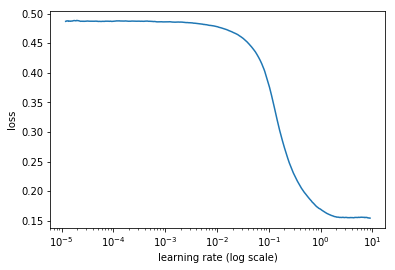

In [27]:
learn.lr_find()
learn.sched.plot()

In [15]:
lr = 1e-1
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                        
    0      0.140341   0.128564   0.49423   



[0.12856445, 0.4942300227428652]

In [16]:
lr = [1e-5, 1e-3, 1e-1]
learn.unfreeze()

In [17]:
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                           
    0      0.120945   0.10522    0.494329  



[0.10522019, 0.49432877390444296]

In [18]:
learn.save('resnext101_full_1')

In [13]:
learn.load('resnext101_full_1')

In [19]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                           
    0      0.116507   0.101977   0.494346  
    1      0.109455   0.099843   0.494403                           
    2      0.11059    0.098319   0.49441                            



[0.098319, 0.49440996894282]

In [20]:
learn.save('resnext101_full_4')

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                           
    0      0.10766    0.099571   0.494357  
    1      0.111386   0.098397   0.494428                           
    2      0.106701   0.099059   0.494351                           
    3      0.113038   0.100209   0.494351                           
    4      0.105731   0.099521   0.494357                           
    5      0.10483    0.096956   0.494408                           
    6      0.107784   0.096271   0.494417                            



[0.096271366, 0.4944165523523013]

In [22]:
learn.save('resnext101_full')

In [23]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                           
    0      0.107101   0.098389   0.494377  
    1      0.101625   0.096913   0.494434                           
    2      0.106401   0.098197   0.494406                           
    3      0.106039   0.095672   0.49443                            
    4      0.104087   0.098351   0.494399                            
    5      0.098945   0.095385   0.494401                           
    6      0.111374   0.097384   0.494441                           
    7      0.108088   0.099439   0.494419                           
    8      0.10652    0.101855   0.494397                           
    9      0.105307   0.100088   0.494445                           
    10     0.106252   0.102597   0.494449                           
    11     0.105153   0.098828   0.494434                           
    12     0.102751   0.099297   0.494445                            
    13     0.103994   0.098558   0.494421                

[0.098558456, 0.4944209412887291]

In [24]:
learn.save('resnext101_cyclelen_2')

# 0.3 Dropout Resnext 101 on full data

In [9]:
arch = resnext101_64
batch_size = 4
img_size = 424

solution_csv = f'{PATH}training_solutions_rev1.csv'

transforms = tfms_from_model(arch, img_size, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'images_training_rev1', solution_csv, test_name='images_test_rev1',
                                    val_idxs=[0, 1], tfms=transforms, bs=batch_size,
                                    suffix='.jpg')

ps = 0.3
learn = ConvLearner.pretrained(arch, data, ps=ps)
metrics = []
learn.crit = rmse

In [ ]:
lr = 1e-1
learn.fit(lr, 1)

learn.save('resnext101_point3dropout_fulldata_pre')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  7%|▋         | 1053/15394 [02:29<33:55,  7.05it/s, loss=0.154]

In [10]:
learn.load('resnext101_point3dropout_fulldata_pre')
lr = [1e-5, 1e-3, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)

learn.save('resnext101_point3dropout_fulldata_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                           
    0      0.114737   0.157427   0.432432  



In [ ]:
learn.fit(lr, 3, cycle_len=1)

learn.save('resnext101_point3dropout_fulldata_2')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 99%|█████████▉| 15314/15394 [2:30:47<00:47,  1.69it/s, loss=0.116] 

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.save('resnext101_point3dropout_fulldata_3')

In [ ]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

learn.save('resnext101_point3dropout_fulldata_4')

In [ ]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

learn.save('resnext101_point3dropout_fulldata_5')

In [23]:
learn.load('resnext101_point3dropout_fulldata_5')

### Without TTA

In [24]:
preds = np.exp(learn.predict(is_test=True))

In [25]:
df = pd.DataFrame(preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnext101_full_data.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

/home/farlion/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnext101_full_data.gz

### With TTA

In [ ]:
aug_preds, y = learn.TTA(is_test=True)
avg_preds = np.mean(aug_preds, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(avg_preds)
df.columns = data.classes
df.insert(0, 'GalaxyId', [filename[17:-4] for filename in data.test_ds.fnames])

SUBMISSION_PATH = f'{PATH}submissions/'
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnext101_full_data_with_TTA.gz'

os.makedirs(SUBMISSION_PATH, exist_ok=True)
df.to_csv(SUBMISSION_NAME, compression='gzip', index=False)
FileLink(SUBMISSION_NAME)

In [21]:
FileLink(SUBMISSION_NAME)

/home/farlion/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnext101_full_data_with_TTA.gz

In [22]:
SUBMISSION_NAME = f'{SUBMISSION_PATH}resnext101_full_data.gz'
FileLink(SUBMISSION_NAME)

/home/farlion/fastai/courses/dl1/homework/tylerchallenges/data/galaxies/submissions/resnext101_full_data.gz